## Multi-Class Classification

We will follow a simple approach that will compress the essential information from the images into a latent space and a neural network will then be trained on that latent space (plus some noise for robustness).

### Setup
- PyTorch 2.6.0
- NVIDIA A10G
- Ubuntu 22.04

### Approach

- We will use ResNet18 with pretrained weights for feature extraction from images.
- We will remove the last layer and change the first layer to make it compatible with a batch size of 64.
- The noise vector will be generated from a normal distribution and added to the latent vector.
- The noisy latent will be passed to a simple MLP with a dropout layer to add some more robustness.
- At the end, we will look at OvR ROC-AUC score and the corresponding plot.

In [72]:
import os
import numpy as np

TRAIN_PATH = "./test1/dataset/train/"
VAL_PATH = "./test1/dataset/val/"

classes = ['no', 'sphere', 'vort']
X_train, y_train = [], []

for cls in classes:
    for file in os.listdir(TRAIN_PATH + cls):
        X_train.append(np.load(TRAIN_PATH + cls + '/' + file).squeeze())
        y_train.append(cls)

X_val, y_val = [], []
for cls in classes:
    for file in os.listdir(VAL_PATH + cls):
        X_val.append(np.load(VAL_PATH + cls + '/' + file).squeeze())
        y_val.append(cls)

In [4]:
from collections import Counter

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

Counter(y_train), Counter(y_val)

(Counter({'no': 10000, 'sphere': 10000, 'vort': 10000}),
 Counter({'no': 2500, 'sphere': 2500, 'vort': 2500}))

Therefore, the data is distributed uniformly. Let us move on to creating the dataloaders,

In [37]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize

class image_loader(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.class_map = {'no':[0], 
                          'sphere':[1],
                          'vort':[2]}
        self.transform = Compose([
            ToTensor(),
            Resize((224, 224)),
        ])
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(self.images[idx])
        return img, torch.Tensor(self.class_map[self.labels[idx]])
    
train_data = image_loader(X_train, y_train)
test_data = image_loader(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

**We want to resize the image to (224, 244) so as to make them compatible with ResNet18.**

In [ ]:
next(iter(train_loader))

[tensor([[[[0.0111, 0.0117, 0.0126,  ..., 0.0146, 0.0124, 0.0099],
           [0.0117, 0.0111, 0.0104,  ..., 0.0107, 0.0102, 0.0099],
           [0.0123, 0.0104, 0.0084,  ..., 0.0082, 0.0092, 0.0105],
           ...,
           [0.0113, 0.0102, 0.0092,  ..., 0.0148, 0.0114, 0.0072],
           [0.0068, 0.0074, 0.0084,  ..., 0.0138, 0.0115, 0.0080],
           [0.0012, 0.0050, 0.0091,  ..., 0.0123, 0.0111, 0.0086]]],
 
 
         [[[0.0087, 0.0136, 0.0170,  ..., 0.0091, 0.0080, 0.0074],
           [0.0099, 0.0121, 0.0144,  ..., 0.0118, 0.0099, 0.0080],
           [0.0105, 0.0100, 0.0112,  ..., 0.0140, 0.0112, 0.0080],
           ...,
           [0.0107, 0.0116, 0.0128,  ..., 0.0119, 0.0126, 0.0140],
           [0.0123, 0.0117, 0.0109,  ..., 0.0114, 0.0108, 0.0112],
           [0.0148, 0.0117, 0.0082,  ..., 0.0102, 0.0080, 0.0074]]],
 
 
         [[[0.0035, 0.0082, 0.0129,  ..., 0.0076, 0.0076, 0.0070],
           [0.0076, 0.0085, 0.0096,  ..., 0.0080, 0.0073, 0.0070],
           [0.0111

The batch looks good, let's move to the model building section,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models

class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load ResNet18
        resnet = models.resnet18(pretrained=True)
        # Remove the last layer
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.encoder[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

class NoiseClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, latent):
        return self.fc(latent)

class ResNetNoiseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = ResNetEncoder()
        encoded_dim = 512 # Final vector of ResNet18 has a shape of 512
        self.classifier = NoiseClassifier(encoded_dim, num_classes)
    
    def forward(self, x, noise):
        encoded_x = self.encoder(x)
        noisy_latent = encoded_x + noise 
        classification = self.classifier(noisy_latent)
        return classification

# Training function
def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for x, y in progress_bar:
            x = x.cuda().float()
            y = y.squeeze(1).long().cuda()
            # Reducing the magnitude of the noise to avoid too much deviation from the original image
            noise = 0.1 * torch.randn(x.size(0), 512).cuda().float()
            optimizer.zero_grad()
            classification = model(x, noise)
            loss = criterion(classification, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            progress_bar.set_postfix(loss=loss.item())
        
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss / len(dataloader)}")

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Evaluating")

    y_pred = torch.Tensor().cuda()
    
    with torch.no_grad():
        for x, y in progress_bar:
            x = x.cuda().float()
            y = y.squeeze(1).long().cuda()
            noise = 0.1 * torch.randn(x.size(0), 512).cuda().float()
            classification = model(x, noise)
            # The predictions will be used to calculate the metrics
            y_pred = torch.cat([y_pred, nn.Softmax(dim=1)(classification)])
            loss = criterion(classification, y)
            total_loss += loss.item()
            
            progress_bar.set_postfix(loss=loss.item())
    
    y_pred = y_pred.cpu()
    print(f"Evaluation Loss: {total_loss / len(dataloader)}")
    return y_pred

model = ResNetNoiseModel(num_classes=3).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train(model, train_loader, criterion, optimizer, num_epochs=10)
y_pred = evaluate(model, test_loader, criterion)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s, loss=1.11]

Epoch 1/10: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s, loss=0.896]


Epoch 1/10, Average Loss: 1.0500923096498191


Epoch 2/10: 100%|██████████| 469/469 [00:35<00:00, 13.03it/s, loss=0.388]


Epoch 2/10, Average Loss: 0.5152008765097111


Epoch 3/10: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s, loss=0.291] 


Epoch 3/10, Average Loss: 0.2888067308138174


Epoch 4/10: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s, loss=0.237] 


Epoch 4/10, Average Loss: 0.23773058279872195


Epoch 5/10: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s, loss=0.259] 


Epoch 5/10, Average Loss: 0.1983311168198138


Epoch 6/10: 100%|██████████| 469/469 [00:35<00:00, 13.09it/s, loss=0.112] 


Epoch 6/10, Average Loss: 0.16624200166955685


Epoch 7/10: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s, loss=0.14]  


Epoch 7/10, Average Loss: 0.14823855843736547


Epoch 8/10: 100%|██████████| 469/469 [00:36<00:00, 13.03it/s, loss=0.134] 


Epoch 8/10, Average Loss: 0.12638686780633132


Epoch 9/10: 100%|██████████| 469/469 [00:35<00:00, 13.04it/s, loss=0.133]  


Epoch 9/10, Average Loss: 0.10557794162451523


Epoch 10/10: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s, loss=0.0707] 


Epoch 10/10, Average Loss: 0.0924271395219478


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 27.77it/s, loss=0.319]

Evaluation Loss: 0.242144891581798


In [ ]:
# Saving the model
torch.save(model, "model.pt")

In [ ]:
from sklearn.metrics import roc_auc_score

# Creating labels for true values
class_map = {'no':0., 
            'sphere':1.,
            'vort':2.}
func = np.vectorize(lambda x: class_map[x])
y_true = func(y_val)

auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')
print("Multi-Class ROC AUC Score:", auc_score)

Multi-Class ROC AUC Score: 0.9835185333333333


The ROC AUC score is quite decent, we will now plot the curve (**the boilerplate code for the curve was generated using GPT4**),

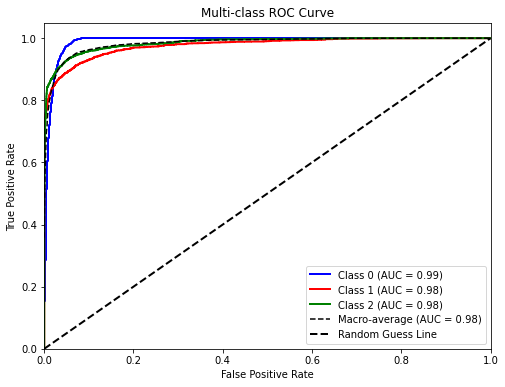

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = y_pred.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8, 6))
colors = ["blue", "red", "green"]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot(all_fpr, mean_tpr, color="black", linestyle="--", label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='Random Guess Line', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.show()

## End